# SCRIPT FOR ANALYSIS OF CELLS ANALYZED WITH Xenium

This notebook is used to identify cell populations from a Xenium dataset. The analysis is based on Scanpy (documentation in  https://scanpy.readthedocs.io/en/stable/index.html) and Squidpy (documentation in https://squidpy.readthedocs.io/en/stable/)

## Loading the packages

We import the packages needed for it. If something fails, means that we haven't installed something in the environment

In [5]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
#from xb.plotting import map_of_clusters
#import squidpy as sq

In [ ]:
def map_of_clusters(adata,key='leiden',clusters='all',size=8,background='white',figuresize=(10,7),save=None,format='pdf'):		

      #PARAMETERS TO MODIFY:		
     #-key: the terms in adata.obs that you want to plot		
     #-clusters:'all' for plotting all clusters in a single plot, 'individual': for plots of individual genes, or ['3','5'] (your groups		
     #          between square brackets to plot only some clusters		
     #-size: to change the size of your spots		
     #-background: to change the color of the background		
     #-figuresize: to specify the size of your figure		
     #-save: if you want to save your figure, give the PATH of the folder where you want to save it		
     #-format: specify the format in which you want to save your figure		
     try:		
         adata.obs[key]=adata.obs[key].astype(int)		
         colors=dict(zip(np.unique(adata.obs[key]),adata.uns[key+'_colors']))		
     except:		
         colors=dict(zip(np.unique(adata.obs[key]),adata.uns[key+'_colors']))		
     #cl.apply(lambda x: colors[x])		
     plt.rcParams['figure.facecolor'] = background		
     if clusters=='all':		
         cl=adata.obs[key]		
         plt.figure(figsize=figuresize)		
         figa=plt.scatter(x=adata.obs.X,y=adata.obs.Y,c=cl.apply(lambda x: colors[x]),s=size,linewidths=0, edgecolors=None)		
         plt.axis('off')		
         if not save==None:		
             plt.savefig(save +'/map_all_clusters_'+str(size)+'_'+background+'_'+key+'.'+format)		
     elif clusters=='individual':		
         cl=adata.obs[key]		
         for each in adata.obs[key].unique():		
             adatasub=adata[adata.obs[key]==each]		
             plt.figure(figsize=figuresize)		
             plt.scatter(x=adata.obs.X,y=adata.obs.Y,c='grey',s=size/5,linewidths=0, edgecolors=None)		
             cl=adatasub.obs[key]		
             plt.scatter(x=adatasub.obs.X,y=adatasub.obs.Y,c=cl.apply(lambda x: colors[x]),s=size,linewidths=0, edgecolors=None)		
             plt.axis('off')		
             plt.title('Group: '+ str(each))		
             if not save==None:		
                 plt.savefig(save +'/map_inidivdual_cluster_'+str(each)+'_'+str(size)+background+'_'+key+'.'+format)		
     else:		
         adatasub=adata[adata.obs[key].isin(clusters)]		
         plt.figure(figsize=figuresize)		
         plt.scatter(x=adata.obs.X,y=adata.obs.Y,c='grey',s=size/5,linewidths=0, edgecolors=None)		
         cl=adatasub.obs[key]		
         plt.scatter(x=adatasub.obs.X,y=adatasub.obs.Y,c=cl.apply(lambda x: colors[x]),s=size,linewidths=0, edgecolors=None)		
         plt.axis('off')		
         plt.legend()		
         if not save==None:		
                 s=''		
                 for element in clusters:		
                     s=s+str(element)		
                 print(s)		
                 plt.savefig(save +'/map_group_of_clusters_'+str(s)+'_'+str(size)+background+'_'+key+'.'+format)		
 #        plt.title('Group: '+ paste(clusters))		

Importing the data and creating an anndata object

We import the adata object for each of the three technical replicates. We remove articitial/control genes and we add a tag to every cell to distinguish the replicate they are comming from

In [ ]:
outpath=r'/media/external/testserver/maria_e/CRC/CRC/xenium_processing/combined_adata/' # path where to save the nuclei adata
adata=sc.read(outpath+'/adata_input.h5ad')

We now save the raw data in adata.raw and apply normalization and log-transformation to minimize the effect of outliers. We also scale the data to give the same importance to all genes in clustering

In [ ]:
adata=adata[:,[g for g in adata.var.index if 'UnassignedCodeword' not in g ]]
adata=adata[:,[g for g in adata.var.index if 'NegControlCodeword' not in g ]]

In [ ]:
adata.raw=adata
sc.pp.filter_cells(adata,min_genes=8)
sc.pp.filter_cells(adata,min_counts=20)
adata.layers['raw']=adata.X
sc.pp.normalize_total(adata, target_sum=None)
sc.pp.log1p(adata)
#sc.pp.scale(adata) ####note that we are scaling

# Dimensional reduction and clustering

We apply principal component analysis to find the appropiate nubmer of components to use to perform dimensionality reduction and clustering

In [ ]:
adata

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.pca_variance_ratio(adata, log=False,n_pcs=50)

We select to go with the top X first principal components to look for the nearest neighbors. We are going to represent our data using graph-based methods, like UMAP. For this, we first need to create a graph by linking each cell to the n closest neighbors (n_neighbors) in the dataset. We can select the numbers of principal components to use

In [ ]:
sc.pp.neighbors(adata, n_neighbors=12, n_pcs=0)

We can, then, run clustering, by calling either leiden or louvain clustering. By changing the parameter "resolution" we will generate more or less clusters. Higher resolution means more clusters. The clusters (groups of cells) are indepent from its visualization, which we will create using UMAP later on

In [ ]:
sc.tl.umap(adata,min_dist=0.1)

In [ ]:
#sc.tl.leiden(adata,resolution=2.0,key_added='leiden_2_0')
sc.tl.leiden(adata,resolution=1.0,key_added='leiden_1_0')
#sc.tl.leiden(adata,resolution=0.6,key_added='leiden_0_6')

In [ ]:
sc.tl.leiden(adata,resolution=1.0,key_added='leiden_1_0')

To VISUALIZE the diversity of our cells, We perfrom UMAP. The closest two spots are in UMAP, the more similar they will be. With the comand sc.tl.umap. we CALCULATE the UMAP embedding. With sc.pl.umap will VISUALIZE the UMAP.

In [ ]:
adata.write(outpath+'/adata_after_leiden_noscale.h5ad')

In [ ]:
adata=sc.read(outpath+'/adata_after_leiden_noscale.h5ad')

In [ ]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(10,10))
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.umap(adata,color=['leiden_1_0','sample'],s=0.1,ncols=1,legend_loc='on data',save='CRC_leiden_1_0.pdf')

In [ ]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(6,4))
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.umap(adata,color=['total_counts'],s=0.1,ncols=1,vmax='p99')

On top of the UMAP you can visualize any variable that you might be interested (a metadata column or gene expression). We need to modify the parameter "color" to visualize the appropiate variable on the UMAP

In [ ]:
keya='leiden_1_0'
adata.obs['X']=adata.obs['x_centroid']*4.70588
adata.obs['Y']=adata.obs['y_centroid']*4.70588
adata.obs['X_umap']=list(pd.DataFrame(adata.obsm['X_umap'])[0])
adata.obs['Y_umap']=list(pd.DataFrame(-adata.obsm['X_umap'])[1])
adata.obs['sample'].unique()
for rep in adata.obs['sample'].unique():
    adatasub=adata[adata.obs['sample']==rep]
    adatasub.obs[keya]=adatasub.obs[keya].astype(str)
    sc.pl.umap(adatasub,color=keya)
    import seaborn as sns
    map_of_clusters(adatasub,key=keya,size=4,background='white',clusters='all',save='/media/external/testserver/maria_e/CRC/CRC/clusters_tissues',figuresize=(round(adatasub.obs['X'].max()/2000),round(adatasub.obs['Y'].max()/2000)))


## For Final Figures

In [6]:
adata=sc.read('/home/maresc/bamse_mn_moldia/maria_e/CRC/adata_manuscript_corrected.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 1024518 × 342
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample', 'n_genes', 'n_counts', 'leiden_1_0', 'unique_id', 'F1_260KS_HS_specific', 'F2_234_KS_LS_specific', 'F3_Luminal area', 'F4_Stemness', 'F5_DNA_repair', 'F6_218KS_HS_specific', 'F7_253KS_LS_specific', 'F8_Lumen facing, stress and inflammation associated', 'F9_immune_related', 'F10_G1 signature', 'F11_immune_signature', 'Cell_types', 'Niches', 'myeloid_subclusters', 'condition'
    uns: 'combined_clusters_colors', 'leiden_1_0', 'leiden_3_0', 'leiden_3_0_colors', 'log1p', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_umap', 'factors', 'spatial'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

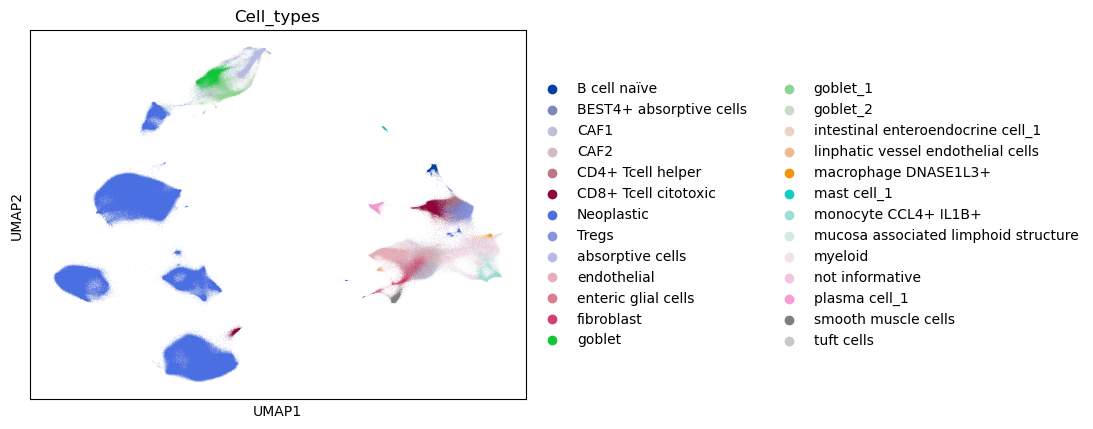

In [9]:
import matplotlib

# Set font type for vector output
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sc.pl.umap(adata,color='Cell_types',show=False)
plt.savefig('/home/maresc/bamse_mn_moldia/maria_e/CRC/final_UMAP_combined_clusters.pdf')

# Subclustering of non-neoplastic clusters

In [ ]:
interesting_clusters = ['8','18','6','10','16','13','14','4','2','17','11','7','12']

In [ ]:
adata.obs.leiden_1_0

In [ ]:
subcluster_data = adata[adata.obs['leiden_1_0'].astype(str).isin(interesting_clusters)].copy()

In [ ]:
subcluster_data

In [ ]:
sc.pp.neighbors(subcluster_data, n_neighbors=7, n_pcs=0)
sc.tl.umap(subcluster_data,min_dist=0.1)
sc.tl.leiden(subcluster_data,resolution=2.0,key_added='leiden_2_0_nei7')

In [ ]:
subcluster_data.write(outpath+'/subcluster_data_after_leiden_neigh7_res2_noscale.h5ad')

In [ ]:
subcluster_data=sc.read('/media/external/testserver/maria_e/CRC/CRC/xenium_processing/combined_adata/subcluster_data_after_leiden_neigh7_res2_noscale.h5ad')

In [ ]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(10,10))
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.umap(subcluster_data,color=['leiden_2_0_nei7','sample'],s=0.1,ncols=1,legend_loc='on data',save='subcluster_CRC_nonneoplastic_leiden_2_0_nei7.pdf')

# Calculating frequencies

In [ ]:
ctb=pd.crosstab(subcluster_data.obs['leiden_2_0_nei7'],subcluster_data.obs['sample'])

In [ ]:
subcluster_data.obs

In [ ]:
keya

In [ ]:
sc.tl.rank_genes_groups(subcluster_data, groupby='leiden_2_0_nei7', method='wilcoxon')
sc.tl.dendrogram(subcluster_data,groupby='leiden_2_0_nei7')
sc.pl.rank_genes_groups_dotplot(subcluster_data, n_genes=3, swap_axes=True,save='CRC_leiden_0_nei7deg_dotplot.pdf')

In [ ]:
sc.pl.rank_genes_groups(subcluster_data, n_genes=5, swap_axes=True,fontsize=20,save='CRC_leiden2_0_nei7deg.pdf')

In [ ]:
keya='leiden_2_0_nei7'
subcluster_data.obs['X']=subcluster_data.obs['x_centroid']*4.70588
subcluster_data.obs['Y']=subcluster_data.obs['y_centroid']*4.70588
subcluster_data.obs['X_umap']=list(pd.DataFrame(subcluster_data.obsm['X_umap'])[0])
subcluster_data.obs['Y_umap']=list(pd.DataFrame(-subcluster_data.obsm['X_umap'])[1])
subcluster_data.obs['sample'].unique()
for rep in subcluster_data.obs['sample'].unique():
    subcluster_datasub=subcluster_data[subcluster_data.obs['sample']==rep]
    subcluster_datasub.obs[keya]=subcluster_datasub.obs[keya].astype(str)
    sc.pl.umap(subcluster_datasub,color=keya)
    import seaborn as sns
    map_of_clusters(subcluster_datasub,key=keya,size=4,background='white',clusters='all',save='/media/external/testserver/maria_e/CRC/CRC/clusters_tissues',figuresize=(round(subcluster_datasub.obs['X'].max()/2000),round(subcluster_datasub.obs['Y'].max()/2000)))

# Annotating clusters

Please input a csv with a 2 columns, one for the cluster number and one for the cell type name that you want to give to each cluster. Add the path to the csv below

In [ ]:
class_ann=pd.read_csv(r'/media/external/testserver/maria_e/CRC/CRC/xenium_processing/annotaded_subclusters_noneoplastic.csv',sep=';')

In [ ]:
class_ann

In [ ]:
cls=dict(zip(class_ann['Cluster'],class_ann['Interpretation']))
subcluster_data.obs['cell type']=subcluster_data.obs['leiden_2_0_nei7'].astype(int).map(cls)

In [ ]:
subcluster_data

In [ ]:
subcluster_data.obs

In [ ]:
subcluster_data.obs.leiden_2_0_nei7

In [ ]:
sc.pl.umap(subcluster_data,color='cell type')

In [ ]:
subcluster_data.write(outpath+'/subcluster_data_annotated.h5ad')

In [ ]:
import anndata

# Load the concatenated AnnData object
concatenated_path = "/media/external/testserver/maria_e/CRC/CRC/xenium_processing/combined_adata/subcluster_data_annotated_obsm.h5ad"
adata_concatenated = sc.read_h5ad(concatenated_path)

# Get unique sample tags
sample_tags = adata_concatenated.obs['sample'].unique()

# Split the concatenated AnnData object into individual AnnData objects
individual_adatas = {}
for sample_tag in sample_tags:
    mask = (adata_concatenated.obs['sample'] == sample_tag)
    individual_adatas[sample_tag] = adata_concatenated[mask].copy()

In [ ]:
adata_concatenated.obs['sample']

In [ ]:
individual_adatas['0021489_Region_1'].write(("/media/external/testserver/maria_e/CRC/CRC/xenium_processing/subclusters__noneoplastic_sample/0021489_Region_1_obsm"+'.h5ad'))

In [ ]:
individual_adatas['0021489_Region_2'].write(("/media/external/testserver/maria_e/CRC/CRC/xenium_processing/subclusters__noneoplastic_sample/0021489_Region_2_obsm"+'.h5ad'))

In [ ]:
individual_adatas['0021492_Region_1'].write(("/media/external/testserver/maria_e/CRC/CRC/xenium_processing/subclusters__noneoplastic_sample/0021492_Region_1_obsm"+'.h5ad'))

In [ ]:
individual_adatas['0021492_Region_2'].write(("/media/external/testserver/maria_e/CRC/CRC/xenium_processing/subclusters__noneoplastic_sample/0021492_Region_2_obsm"+'.h5ad'))

# Create obsm 

In [ ]:
adata_human=sc.read("/media/external/testserver/maria_e/CRC/CRC/xenium_processing/combined_adata/subcluster_data_annotated.h5ad")

In [ ]:
adata_human

In [ ]:
# Load the data
sub_main_clusters=sc.read('/media/external/testserver/maria_e/CRC/CRC/xenium_processing/combined_adata/combined_clustering.h5ad')
# Add spatial coordinates in obsm
sub_main_clusters.obsm['spatial'] = sub_main_clusters.obs[['x_centroid', 'y_centroid']].to_numpy()

#Remove xc and yc from obs (OPTIONAL)
#data.obs = data.obs.drop(columns=['xc', 'yc'])
# Write to new h5ad
sub_main_clusters.write('/media/external/testserver/maria_e/CRC/CRC/xenium_processing/combined_adata/combined_clustering_obsm'+'.h5ad')

In [ ]:
sub_main_clusters

In [ ]:
adata_human=sc.read("/media/external/testserver/maria_e/CRC/CRC/xenium_processing/combined_adata/subcluster_data_annotated_obsm.h5ad")

# Converting Xenium(morphology_mip.ome.tif) DAPI to TIFF

In [ ]:
pip install tifffile

In [ ]:
pip install imagecodecs

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import gzip
import shutil
import os.path
from scipy.io import mmread
import tifffile as tf
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import json
from PIL import Image
import os
#import PIL


path='/media/external/testserver/maria_e/CRC/CRC/Xenium/output-XETG00213__0021492__Region_2__20240125__150400' # path to the xenium folder of your input data
outpath='/media/external/testserver/maria_e/CRC/CRC/Xenium/DAPIS/dapi_21492_Region2' # output path. where is your file stored and how is it called? i.e media/documents/image.tif
def format_background(path):
    IM=tf.TiffFile(path+'/morphology_mip.ome.tif')
    position1_series = IM.series[0]
    position1_series.axes
    position1 = position1_series.asarray()
    return position1

IM=format_background(path)
IM=IM.astype('int16')
im=Image.fromarray(IM)
#im=Image.open(path)
division=8 # how many times you want to 
#im.mode='I'
i = im.size   # current size (height,width)
i = i[0]//division, i[1]//division  # new size
newimage = im.resize(i)

newimage.save(outpath+'.tif')

# Join subclustering+annotations to the main clustering anndata

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import gzip
import shutil
import os.path
from scipy.io import mmread
import tifffile as tf
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import json
from PIL import Image
import os
import anndata
# Load your initial AnnData object
initial_anndata = anndata.read_h5ad('/media/external/testserver/maria_e/CRC/CRC/xenium_processing/combined_adata/adata_after_leiden_noscale_obsm.h5ad')

# Load the subclusters and annotations
subclusters_anndata = anndata.read_h5ad('/media/external/testserver/maria_e/CRC/CRC/xenium_processing/combined_adata/subcluster_data_annotated_obsm.h5ad')

In [ ]:
initial_anndata

In [ ]:
subclusters_anndata

In [ ]:
initial_anndata.obs['unique_id']=initial_anndata.obs['cell_id'].astype(str)+'_'+initial_anndata.obs['sample'].astype(str)
subclusters_anndata.obs['unique_id']=subclusters_anndata.obs['cell_id'].astype(str)+'_'+subclusters_anndata.obs['sample'].astype(str)

In [ ]:
dictionary_id_to_celltype=dict(zip(subclusters_anndata.obs['unique_id'],subclusters_anndata.obs['cell type'])) #zip is for pairing one column with another

In [ ]:
initial_anndata.obs['combined_clusters']=initial_anndata.obs['unique_id'].map(dictionary_id_to_celltype)

In [ ]:
initial_anndata.obs['combined_clusters']=initial_anndata.obs['combined_clusters'].astype(str)

In [ ]:
initial_anndata.obs.loc[initial_anndata.obs['combined_clusters']=='nan','combined_clusters']='Neoplastic'#loc for selecting rows and columns,first part is row, and second ('combined_clusters') is columns

In [ ]:
sc.pl.umap(initial_anndata,color='combined_clusters')

In [ ]:
initial_anndata.write_h5ad('/media/external/testserver/maria_e/CRC/CRC/xenium_processing/combined_adata/combined_clustering.h5ad')

In [ ]:
patata = anndata.read_h5ad('/media/external/testserver/maria_e/CRC/adata_with_factors.h5ad')

In [ ]:
patata

In [ ]:
sc.tl.rank_genes_groups(patata, groupby='combined_clusters', method='wilcoxon')
sc.tl.dendrogram(patata,groupby='combined_clusters')
sc.pl.rank_genes_groups_dotplot(patata, n_genes=3, swap_axes=True,save='CRC_240724_dotplot.pdf')

In [ ]:
#to get the curremt working directory where the saved files are being saved when you only type'save' and nothing else. without path
import os
print(os.getcwd())


In [ ]:
sc.pl.rank_genes_groups(patata, n_genes=5, swap_axes=True,fontsize=20,save='CRC_final_ranking.pdf')

## Final annotation clusters

In [ ]:
rename_dict = {
    'colonic crypts (can be stem cells)': 'tuft cells',
    'endothelial_3': 'endothelial',
    'intersticial epithelial cell_1' : 'BEST4+ absorptive cells',
    'epithelial cells non-neoplastic' : 'absorptive cells',
    'B cell active': 'myeloid',
    'CAF/monocyte' : 'myeloid',
    'macrophage' : 'myeloid',
    'macrophages' : 'myeloid',
    'monocyte' : 'myeloid'
    
    
    
    
}
# Apply mapping to create a new column
adata.obs["combined_clusters_renamed"] = adata.obs["combined_clusters"].map(rename_dict).fillna(adata.obs["combined_clusters"])

In [ ]:
adata.obs["combined_clusters_renamed"].value_counts()

# Reading the object again if needed

# Cell type consistency between replicates

In [ ]:
keya='cell type'

In [ ]:
crs=pd.crosstab(adata.obs[keya],adata.obs['sample'])
crs_perc=crs.div(crs.sum(axis=0),axis=1)*100
#crs_perc['celltype_annotation']=crs_perc.index
crs_transpose=crs_perc.transpose()
crs_transpose['sample']=crs_transpose.index
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
crs_transpose.set_index('sample').plot(kind='bar', stacked=True, color=adata.uns[keya+'_colors'])
#plt.savefig('../../figures/celltype_identification_mscoronal/stacked_barplot_celltypes.pdf')

In [ ]:
keya='cell type'
adata.obs['X']=adata.obs['x_centroid']*4.70588
adata.obs['Y']=adata.obs['y_centroid']*4.70588
adata.obs['X_umap']=list(pd.DataFrame(adata.obsm['X_umap'])[0])
adata.obs['Y_umap']=list(pd.DataFrame(-adata.obsm['X_umap'])[1])
adata.obs['sample'].unique()
for rep in adata.obs['sample'].unique():
    adatasub=adata[adata.obs['sample']==rep]
    adatasub.obs[keya]=adatasub.obs[keya].astype(str)
    sc.pl.umap(adatasub,color=keya)
    import seaborn as sns
    map_of_clusters(adatasub,key=keya,size=4,background='white',clusters='all',figuresize=(round(adatasub.obs['X'].max()/2000),round(adatasub.obs['Y'].max()/2000)))

# EXPLORATION OF SOME CLUSTERS

In [ ]:
import scanpy as sc
subcluster_data=sc.read('/media/external/testserver/maria_e/CRC/CRC/xenium_processing/combined_adata/subcluster_data_annotated_obsm.h5ad')


In [ ]:
sc.pl.umap(subcluster_data,color=['TIMP3','IGFBP7','THBS1','VCAN','DPYSL3','MAF'],vmax='p99',ncols=2)#display as percintile 99

In [ ]:
genes_to_plot=['MAF']#,'IGFBP7','THBS1','VCAN','DPYSL3','MAF']
for gene in genes_to_plot:
    for s in subcluster_data.obs['sample'].unique():
        sub=subcluster_data[subcluster_data.obs['sample']==s]
        sc.pl.spatial(sub,color=gene,vmax='p99',spot_size=40)#display as percintile 99

In [ ]:
list(subcluster_data.obs['cell type'].unique())

In [ ]:
selected_clusters=['endothelial/fibroblast_4',
 'endothelial/fibroblast_2',
 'endothelial_3',
 'endothelial/fibroblast_1','endothelial/fibroblast_3','T cell?_3']#,'IGFBP7','THBS1','VCAN','DPYSL3','MAF']
adata_fibro=subcluster_data[subcluster_data.obs['cell type'].isin(selected_clusters)]

In [ ]:
#Differential expression of genes between the selcted clusters
sc.tl.rank_genes_groups(adata_fibro, groupby='cell type', method='wilcoxon')
sc.tl.dendrogram(adata_fibro,groupby='cell type')
sc.pl.rank_genes_groups_dotplot(adata_fibro, n_genes=5, swap_axes=True,save='CRC_final_dotplot_only_fibro_subtypes.pdf')

## Proportions

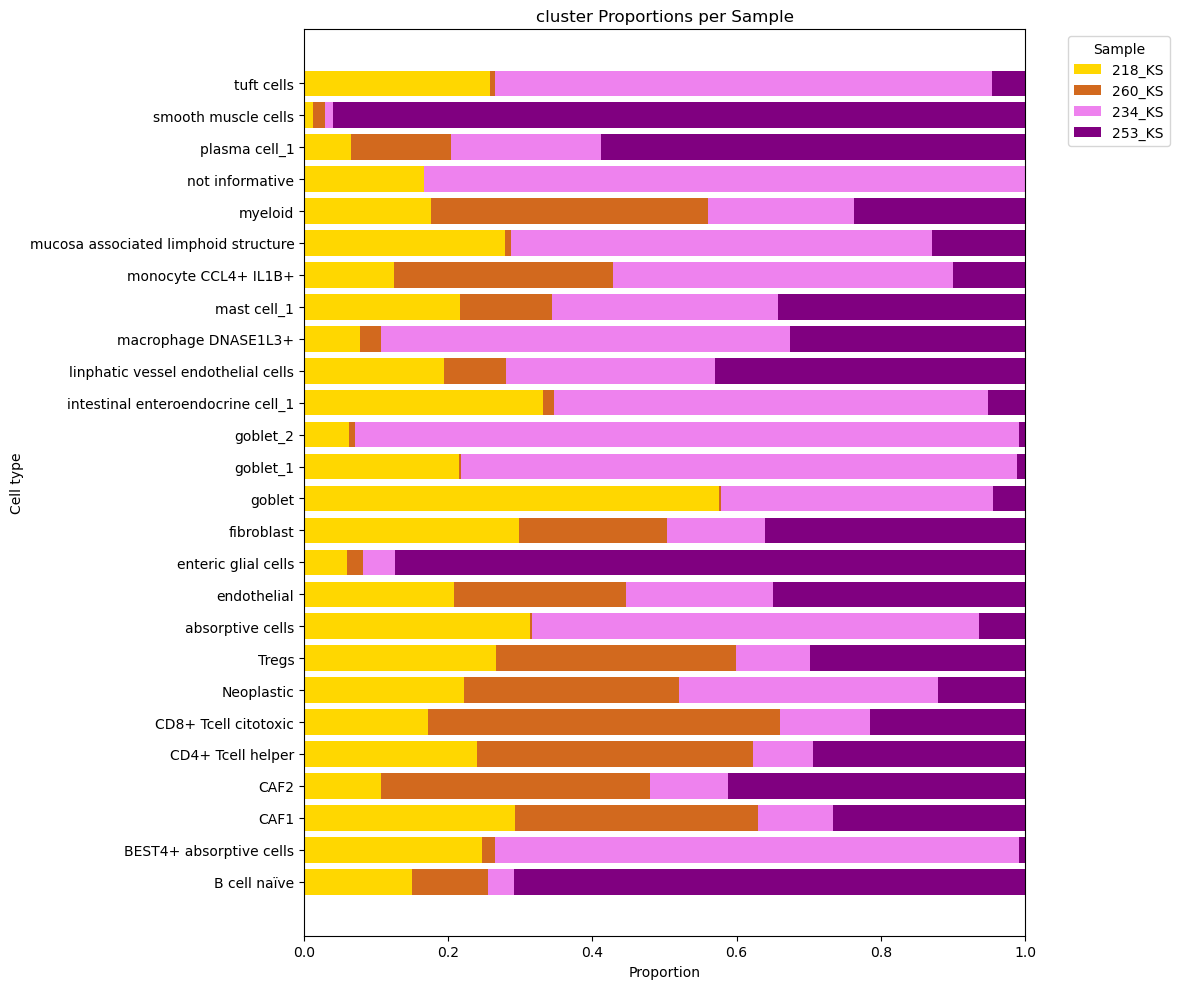

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Tabulate and normalize
counts = pd.crosstab(adata.obs['Cell_types'], adata.obs['sample'])
proportions = counts.div(counts.sum(axis=1), axis=0)

# 2. Define color for each sample (matching visual logic)
sample_colors = {
    '218_KS': 'gold',
    '260_KS': 'chocolate',
    '234_KS': 'violet',
    '253_KS': 'purple'
}

# 3. Create the stacked horizontal barplot
fig, ax = plt.subplots(figsize=(12, 10))
bottom = pd.Series([0] * proportions.shape[0], index=proportions.index)

for sample in proportions.columns:
    ax.barh(
        y=proportions.index,
        width=proportions[sample],
        left=bottom,
        color=sample_colors[sample],
        label=sample
    )
    bottom += proportions[sample]

# 4. Formatting
ax.set_xlabel('Proportion')
ax.set_ylabel('Cell type')
ax.set_title('cluster Proportions per Sample')
ax.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("/home/maresc/bamse_mn_moldia/maria_e/CRC/FINAL_cluster_proportions_per_sample.pdf", dpi=300)
plt.show()


In [ ]:
adata=sc.read('/mnt/DATA/ext_home/mariae/test_storage/maria_e/CRC/adata_manuscript.h5ad')

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='combined_clusters_renamed', method='wilcoxon')
sc.tl.dendrogram(adata,groupby='combined_clusters_renamed')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4, swap_axes=True,save='CRC_manuscript_dotplot.pdf')

In [ ]:
import seaborn as sns

# Generate 26 truly unique and evenly spaced colors
palette = sns.husl_palette(26)

adata.uns['combined_clusters_renamed_colors'] = palette

sc.pl.umap(
    adata,
    color='combined_clusters_renamed',
    s=10,
    legend_loc='right margin',
    frameon=False,
    title='Combined Clusters',
    save='_husl_palette.png',
)
